In [2]:
# pip install -U transformers: شامل مدل های از پیش آموزش داده شده برای پردازش زبان طبیعی است
# pip install -U accelerate: برای مدیریت منابع سخت افزاری است مانند پردازنده های گرافیکی و بهینه سازی مدیریت عملکرد مدل ها هست
# pip install -U datasets: شامل دیتاست های آماده می باشد
# pip install -U bertviz: نحوه ارتباط بین کلمات و جملات در هر لایه BERT را نمایش می دهد
# pip install -U umap-learn: برای کاهش ابعاد می باشد
# pip install seaborn --upgrade: برای رسم و نمایش نمودارها می باشد

In [3]:
!pip install datasets

In [4]:
!pip install evaluate

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import AutoTokenizer  # این کلاس می‌تواند توکن‌ساز مناسب را بر اساس مدل انتخاب شده فراهم کند
from sklearn.model_selection import train_test_split
from datasets import Dataset, DatasetDict
from transformers import AutoModel
import torch
import evaluate # برای محاسبه معیار ارزیابی مدل
from sklearn.metrics import accuracy_score, f1_score
import tensorflow
from tensorflow import keras
from keras.layers import Dense

In [30]:
data = pd.read_csv('../dataset/twitter_multi_class_sentiment.csv')
data.head()

,text,label,label_name
0,i didnt feel humiliated,0,sadness
1,i can go from feeling so hopeless to so damned...,0,sadness
2,im grabbing a minute to post i feel greedy wrong,3,anger
3,i am ever feeling nostalgic about the fireplac...,2,love
4,i am feeling grouchy,3,anger


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16000 entries, 0 to 15999
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   text        16000 non-null  object
 1   label       16000 non-null  int64 
 2   label_name  16000 non-null  object
dtypes: int64(1), object(2)
memory usage: 375.1+ KB


In [8]:
data.isna().sum()

,0
text,0
label,0
label_name,0


In [9]:
data['label'].value_counts()

,count
label,
1,5362
0,4666
3,2159
4,1937
2,1304
5,572


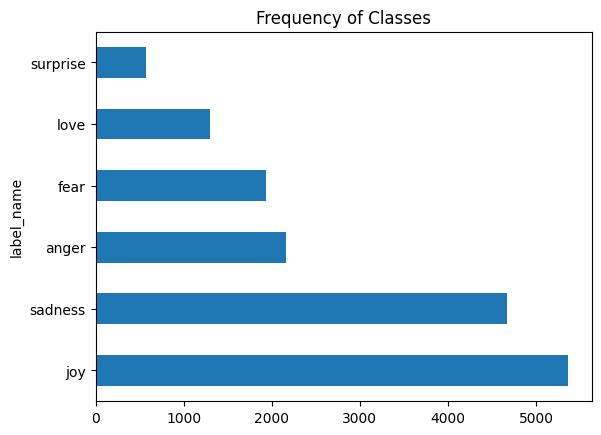

In [10]:
label_counts = data['label_name'].value_counts()
label_counts.plot.barh()
plt.title('Frequency of Classes')
plt.show()

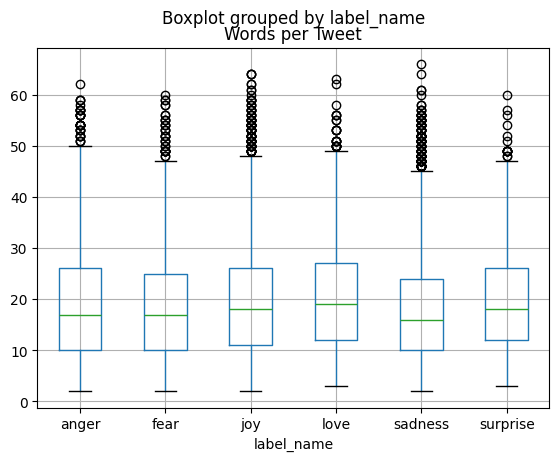

In [11]:
data['Words per Tweet'] = data['text'].str.split().apply(len)
data.boxplot('Words per Tweet', by= 'label_name');

In [12]:
# عملیات توکن سازی برای متن را انجام می دهیم، توکن‌سازی فرآیندی است که متن را به اجزای کوچک‌تر، معمولاً کلمات، تبدیل می‌کند

model_ckpt = "bert-base-uncased"  # متغییری را تعریف می کنیم و نام مدل برت را در آن ذخیره می کنیم
tokenizer = AutoTokenizer.from_pretrained(model_ckpt) # یک نمونه از توکن ساز را با استفاده از مدل برت که قبلا تعیین شده ایجاد می کند
text = "I love machine learning! Tokenization is awesome!!" # یک متن برای تست و آزمایش می نویسیم
encoded_text = tokenizer(text) # متن را بعنوان ورودی به توکن می دهیم و آن را به فرم کدگذاری شده (انکد) تبدیل می کند
print(encoded_text)

{'input_ids': [101, 1045, 2293, 3698, 4083, 999, 19204, 3989, 2003, 12476, 999, 999, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [13]:
# در خروجی بالا موارد به شرح ذیل است
# input_ids: این قسمت، نمایشی عددی از متن ورودی است که هر کلمه یا توکن را به یک شناسه عددی خاص تبدیل می‌کند، عدد 101 نشان دهنده آغاز جمله و عدد 102 نشان دهنده پایان جمله هست
# token_type_ids:  این بخش نشان می‌دهد که هر توکن متعلق به کدام جمله یا بخش از متن است. در تحلیل‌های دو جمله‌ای، این شناسه‌ها کمک می‌کنند و در اینجا، تمام مقادیر 0 هستند، زیرا فقط یک جمله به مدل داده شده و همه توکن‌ها مربوط به یک بخش (بخش صفرم) هستند
# attention_mask: تعیین می کند که کدام توکن ها در محاسبه باید مورد توجه قرار گیرد و کدام ها نباید قرار گیرد و چون تمام اعداد یک است پس یعنی همه توکن‌ها باید پردازش شوند. این حالت زمانی رخ می‌دهد که هیچ توکن اضافی یا خالی در ورودی وجود ندارد

In [14]:
len(tokenizer.vocab), tokenizer.vocab_size, tokenizer.model_max_length
# len(tokenizer.vocab): این خط اندازه واژگان مدل را محاسبه می‌کند این دستور به شما تعداد کل توکن‌های منحصربه‌فردی که توکن‌ساز می‌تواند پردازش کند را نشان می‌دهد. این عدد برابر با اندازه واژگان مدل برت است (به طور معمول ۳۰,۰۰۰ یا بیشتر).
#tokenizer.vocab_size: این ویژگی به طور مستقیم تعداد کل توکن‌های قابل استفاده در توکن‌ساز را به عنوان یک مقدار (عدد صحیح) نشان می‌دهد
#tokenizer.model_max_length: این ویژگی طول حداکثری متنی که مدل می‌تواند پردازش کند را نشان می‌دهد. یعنی حداکثر تعداد توکن‌هایی که مدل برت می‌تواند در یک مرحله (به طور معمول ۵۱۲ توکن) بپذیرد.
# این کد سه ویژگی کلیدی توکن‌ساز برت را استخراج می‌کند: اندازه واژگان، تعداد توکن‌ها و حداکثر طول متن قابل پردازش

(30522, 30522, 512)

In [15]:
# stratify: برای اینکه توزیع برچسب‌ها (کلاس‌های داده‌ها) در مجموعه‌های آموزشی و تستی مشابه باشد و مدل به صورت متوازن آموزش ببیند
train, test = train_test_split(data, test_size = 0.3, stratify = data['label_name'])
# test_size: یک سوم از مجموعه اولیه تست به عنوان مجموعه اعتبار (validation) جدا می‌شود. در نهایت ۲۰٪ از داده‌ها به تست و ۱۰٪ به اعتبار اختصاص می‌یابد
test, validation = train_test_split(test, test_size = 1/3, stratify = test['label_name'])
train.shape, test.shape, validation.shape

((11200, 4), (3200, 4), (1600, 4))

In [16]:
# یک ساختار دیکشنری مانند است که برای مدیریت چندین مجموعه داده به صورت همزمان (مثلاً مجموعه‌های آموزشی، تست و اعتبار) بسیار مناسب است
dataset = DatasetDict({
    # تبدیل دیتافریم پانداس به شیء دیتاست امکان استفاده از ویژگی‌های پیشرفته کتابخانه دیتاست مانند توکن‌سازی و پیش‌پردازش داده‌ها را فراهم می‌کند
    # preserve_index: این گزینه تعیین می‌کند که شاخص (ایندکس) اصلی دبتافریم حفظ نشود. این موضوع به کار می‌آید تا داده‌ها بدون ستون اضافی برای ایندکس بارگذاری شوند
    'train': Dataset.from_pandas(train, preserve_index = False),
    'test': Dataset.from_pandas(test, preserve_index = False),
    'validation': Dataset.from_pandas(validation, preserve_index = False)
})
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'label_name', 'Words per Tweet'],
        num_rows: 11200
    })
    test: Dataset({
        features: ['text', 'label', 'label_name', 'Words per Tweet'],
        num_rows: 3200
    })
    validation: Dataset({
        features: ['text', 'label', 'label_name', 'Words per Tweet'],
        num_rows: 1600
    })
})

In [17]:
dataset['train'][0], dataset['train'][1]

({'text': 'i still feel very amorous',
  'label': 2,
  'label_name': 'love',
  'Words per Tweet': 5},
 {'text': 'i feel soooo impatient',
  'label': 3,
  'label_name': 'anger',
  'Words per Tweet': 4})

In [18]:
# این تابع به شما امکان می‌دهد تا داده‌ها را به راحتی و به صورت یکپارچه توکن‌سازی کنید
def tokenize(batch):
    # batch['text']: این بخش متن‌هایی که باید توکن‌سازی شوند را از ستون text در ورودی می‌گیرد
    # padding: این گزینه باعث می‌شود توکن‌ساز، ورودی‌ها را با افزودن padding به طول مشخصی برساند تا همه ورودی‌ها طول یکسانی داشته باشند. این ویژگی برای پردازش دسته‌ای (batch processing) مهم است.
    # truncation: این گزینه باعث می‌شود اگر متنی طولانی‌تر از حداکثر طول قابل پردازش توسط مدل باشد، آن را کوتاه کند
    temp = tokenizer(batch['text'], padding=True, truncation=True)
    return temp

print(tokenize(dataset['train'][:2]))

{'input_ids': [[101, 1045, 2145, 2514, 2200, 16095, 3560, 102], [101, 1045, 2514, 17111, 9541, 17380, 102, 0]], 'token_type_ids': [[0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 0]]}


In [19]:
# این روش برای پیش‌پردازش داده‌ها به کار می‌رود تا تمام مجموعه داده‌ها را توکن‌سازی کند و نتایج را به مجموعه داده اضافه کند. این باعث می‌شود داده‌ها آماده ورود به مدل شوند
# tokenize: این همان تابعی است که قبلاً تعریف کردیم و عمل توکن‌سازی روی داده‌ها را انجام می‌دهد
# batched: این آرگومان تعیین می‌کند که تابع tokenize باید به صورت دسته‌ای (batch) روی داده‌ها اعمال شود، نه نمونه به نمونه این گزینه باعث می‌شود پردازش داده‌ها سریع‌تر و کارآمدتر انجام شود، به خصوص وقتی با مجموعه داده‌های بزرگ کار می‌کنیم
# batch_size: این آرگومان مشخص می‌کند که اندازه دسته‌ها (batch) به طور پیش‌فرض توسط کتابخانه تنظیم شود
emotion_encoded = dataset.map(tokenize, batched=True, batch_size=None)

Map:   0%|          | 0/11200 [00:00<?, ? examples/s]

Map:   0%|          | 0/3200 [00:00<?, ? examples/s]

Map:   0%|          | 0/1600 [00:00<?, ? examples/s]

In [20]:
# label2id: به این خاطر استفاده می کنیم که مدل باید برچسب‌های متنی را به اعداد تبدیل کند تا قابل پردازش باشند
#id2label: به این خاطر استفاده می کنیم که هنگام تفسیر خروجی مدل (پیش‌بینی‌ها)، نیاز داریم که شناسه‌های عددی را دوباره به نام‌های قابل خواندن برای انسان تبدیل کنیم

label2id = {x['label_name']:x['label'] for x in dataset['train']}
id2label = {v:k for k,v in label2id.items()}

label2id, id2label

({'love': 2, 'anger': 3, 'joy': 1, 'sadness': 0, 'surprise': 5, 'fear': 4},
 {2: 'love', 3: 'anger', 1: 'joy', 0: 'sadness', 5: 'surprise', 4: 'fear'})

In [21]:
model = AutoModel.from_pretrained(model_ckpt)

In [22]:
# این کد برای دسترسی به تنظیمات مدل بارگیری‌شده به کار می‌رود و جزئیات پیکربندی آن را نمایش می‌دهد
model.config.id2label
model.config

BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.44.2",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

In [23]:
# AutoModelForSequenceClassification: برای بارگیری یک مدل از پیش‌آموزش‌دیده مناسب برای وظایف طبقه‌بندی
# AutoConfig: برای بارگیری یا ایجاد یک پیکربندی برای مدل
from transformers import AutoModelForSequenceClassification, AutoConfig
# len(label2id): این تعداد برای تنظیم پیکربندی مدل مورد نیاز است تا مدل بداند چند کلاس مختلف وجود دارد
num_labels = len(label2id)
# یعنی اگر gpu وجود داشت استفاده کن و در غیر اینصورت از cpu استفاده کن
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
config = AutoConfig.from_pretrained(model_ckpt, label2id=label2id, id2label=id2label)
#این شیء شامل اطلاعاتی مثل تعداد برچسب‌ها و نگاشت‌های مربوط به آن‌ها است که برای شخصی‌سازی پیکربندی مدل مفید است
config = AutoConfig.from_pretrained(model_ckpt, label2id=label2id, id2label=id2label)
model = AutoModelForSequenceClassification.from_pretrained(model_ckpt, config=config).to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [24]:
model.config

BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "sadness",
    "1": "joy",
    "2": "love",
    "3": "anger",
    "4": "fear",
    "5": "surprise"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "anger": 3,
    "fear": 4,
    "joy": 1,
    "love": 2,
    "sadness": 0,
    "surprise": 5
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.44.2",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

In [25]:
# این کلاس به شما اجازه می‌دهد تا تنظیمات و پارامترهای مربوط به فرآیند آموزش مدل را مشخص کنید
from transformers import TrainingArguments
# batch_size: اندازه دسته ها برای هر مرحله آموزش را مشخص می کند و انتخاب اندازه مناسب برای دسته‌ها به تعادل بین استفاده از حافظه و زمان آموزش کمک می‌کند. دسته‌های بزرگ‌تر معمولاً سرعت آموزش را افزایش می‌دهند ولی نیاز به حافظه بیشتری دارند
batch_size = 64
# این مسیر برای ذخیره مدل‌ها و فایل‌های خروجی ایجاد شده در طول فرآیند آموزش به کار می‌رود
training_dir = "bert_base_train_dir"
# output_dir: مشخص کردن محل ذخیره نتایج برای ارزیابی و ادامه آموزش
# overwrite_output_dir: اگر True باشد، محتویات پوشه خروجی در صورت وجود بازنویسی می‌شود و برای جلوگیری از خطا در صورت وجود فایل‌های قدیمی در مسیر خروجی
# num_train_epochs: تعداد دفعاتی که مدل روی کل داده‌های آموزشی آموزش می‌بیند
# learning_rate: نرخ یادگیری که مشخص می‌کند مدل در هر به‌روزرسانی پارامترهای خود چقدر تغییر کند
# per_device_train_batch_size: اندازه دسته برای آموزش در هر دستگاه CPU و GPU
# per_device_eval_batch_size: اندازه دسته برای ارزیابی در هر دستگاه و کمک می‌کند که در زمان ارزیابی حافظه بهینه مصرف شود
# weight_decay: نرخ کاهش وزن که برای جلوگیری از بیش‌برازش استفاده می‌شود و کمک می‌کند مدل از یادگیری بیش از حد پیچیده جلوگیری کند و تعمیم بهتری داشته باشد
# evaluation_strategy: یعنی پس از هر ایپاک مدل ارزیابی می شود و ارزیابی مدل پس از هر دوره کمک می‌کند تا پیشرفت مدل در طول زمان مانیتور شود
# disable_tqdm: اگر مقدار فالس باشد نوار پیشرفت در طول دوره نمایش داده می شود
training_args = TrainingArguments( output_dir=training_dir,
                                  overwrite_output_dir = True,
                                  num_train_epochs = 2,
                                  learning_rate = 2e-5,
                                  per_device_train_batch_size = batch_size,
                                  per_device_eval_batch_size = batch_size,
                                  weight_decay = 0.01,
                                  evaluation_strategy = 'epoch',
                                  disable_tqdm = False
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [26]:
# این کد برای ارزیابی عملکرد مدل با محاسبه دقت پیش‌بینی‌ها در مقایسه با برچسب‌های واقعی استفاده می‌شود
# بارگیری تابع دقت برای محاسبه ارزیابی مدل روی داده‌های پیش‌بینی‌شده و واقعی
accuracy = evaluate.load("accuracy")
def compute_metrics_evaluate(eval_pred):
    # eval_pred: به تابع پاس داده می شود و شامل دو مدل است پیش بینی مدل و برچسب های واقعی و علت استفاده برای دسترسی به مقادیر پیش‌بینی‌ها و برچسب‌ها در داخل تابع است
    predictions, labels = eval_pred
    # مدل معمولاً خروجی احتمال برای هر کلاس را برمی‌گرداند، و با این خط کد، بالاترین احتمال به عنوان پیش‌بینی نهایی برای هر نمونه انتخاب می‌شود
    predictions = np.argmax(predictions, axis=1)
    # برای محاسبه دقت مدل با استفاده از پیش‌بینی‌ها و برچسب‌های واقعی استفاده می‌شود و این خط دقت پیش‌بینی‌های مدل را برمی‌گرداند تا برای ارزیابی عملکرد مدل در طول آموزش یا ارزیابی نهایی استفاده شود
    return accuracy.compute(predictions=predictions, references=labels)

In [27]:
def compute_metrics(pred):
    # برای محاسبه دقت و نمره F1 نیاز به برچسب‌های واقعی داریم تا بتوانیم آن‌ها را با پیش‌بینی‌ها مقایسه کنیم
    labels = pred.label_ids
    # در مدل‌های طبقه‌بندی، پیش‌بینی‌ها معمولاً شامل احتمال‌هایی برای هر کلاس هستند و برچسب با بالاترین احتمال را انتخاب می‌کند
    preds = pred.predictions.argmax(-1)
    # به این معناست که نمره F1 برای هر کلاس محاسبه شده و با توجه به تعداد نمونه‌ها وزن‌دهی می‌شود
    f1 = f1_score(labels, preds, average="weighted")
    # دقت را محاسبه می‌کند که نشان می‌دهد چه درصدی از پیش‌بینی‌ها درست هستند
    acc = accuracy_score(labels, preds)

    return {"accuracy": acc, "f1": f1}

In [28]:
# با استفاده از مدل، داده‌های آموزشی و اعتبارسنجی، و تنظیمات تعریف‌شده، فرآیند آموزش و ارزیابی مدل را مدیریت می‌کند
# مدل از قبل تعریف‌شده (مثلاً AutoModelForSequenceClassification) به Trainer داده می‌شود
# training_args: تعیین پارامترهای مربوط به آموزش مانند تعداد epochها، نرخ یادگیری، اندازه دسته و استراتژی ارزیابی
from transformers import Trainer
trainer = Trainer(model=model, args=training_args,
                  # این تابع (که قبلاً تعریف شده) برای محاسبه دقت و نمره F1 استفاده می‌شود تا عملکرد مدل در طول و پایان آموزش ارزیابی شود
                  compute_metrics=compute_metrics,
                  # مشخص کردن داده‌هایی که برای آموزش مدل استفاده خواهند شد
                  train_dataset = emotion_encoded['train'],
                  # کمک می‌کند تا عملکرد مدل به صورت دوره‌ای ارزیابی شده و مانیتور شود
                  eval_dataset = emotion_encoded['validation'],
                  # برای پردازش داده‌های ورودی و آماده‌سازی آن‌ها برای مدل به توکنایزر نیاز دارد
                  tokenizer = tokenizer)

In [31]:
!pip install wandb

In [32]:
wandb login

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [33]:
# این متد خروجی‌هایی مانند لاگ‌های مربوط به پیشرفت آموزش، معیارهای ارزیابی دوره‌ای، و وضعیت نهایی مدل را نمایش می‌دهد
trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Currently logged in as: msalarvand1990 (msalarvand1990-mpa). Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.450387,0.846875,0.831525
2,No log,0.280839,0.905000,0.903881


TrainOutput(global_step=350, training_loss=0.6881948852539063, metrics={'train_runtime': 333.3969, 'train_samples_per_second': 67.187, 'train_steps_per_second': 1.05, 'total_flos': 1001502421516800.0, 'train_loss': 0.6881948852539063, 'epoch': 2.0})

In [34]:
# این کد پیش‌بینی مدل را روی داده‌های تست اجرا می‌کند و معیارهای ارزیابی را برای این پیش‌بینی‌ها نمایش می‌دهد
#برای اجرای پیش‌بینی مدل روی داده‌های جدید (در اینجا، داده‌های تست) و ارزیابی عملکرد آن روی این داده‌ها
preds_output = trainer.predict(emotion_encoded['test'])
# برای نمایش یا استفاده از معیارهای ارزیابی مدل که روی داده‌های تست محاسبه شده‌اند
preds_output.metrics

{'test_loss': 0.2759038507938385,
 'test_accuracy': 0.906875,
 'test_f1': 0.9062730985958986,
 'test_runtime': 12.496,
 'test_samples_per_second': 256.083,
 'test_steps_per_second': 4.001}

In [ ]:
# test_loss: میزان خطا را نشان می‌دهد که مدل چقدر به پیش‌بینی درست نزدیک بوده است. مقدار کمتر خطا، نشان‌دهنده پیش‌بینی بهتر مدل است
# test_accuracy: نشان می‌دهد چند درصد از پیش‌بینی‌ها توسط مدل درست بوده‌اند
# test_f1: نمره F1 میانگینی از معیارهای دقت (precision) و یادآوری (recall) است و به ویژه برای مجموعه داده‌های نامتوازن کاربردی است
# test_runtime: این اطلاعات نشان می‌دهد که فرآیند پیش‌بینی چقدر طول کشیده است و به بهینه‌سازی یا ارزیابی کارایی مدل کمک می‌کند
# test_samples_per_second: این معیار نشان‌دهنده سرعت مدل در پردازش داده‌ها است و می‌تواند برای ارزیابی عملکرد پردازشی مدل مفید باشد
# test_steps_per_second: این معیار نشان می‌دهد که مدل چقدر سریع در هر گام پیش می‌رود و می‌تواند به شناسایی محدودیت‌های سرعت پردازش و بهبود کارایی کمک کند

In [35]:
# این کد مربوط به استخراج پیش‌بینی‌ها و برچسب‌های واقعی از خروجی مدل است و سپس آماده‌سازی آن‌ها برای مقایسه عملکرد مدل (مثلاً محاسبه دقت یا نمره F1)
# این خط پیش‌بینی‌های مدل را از خروجی (preds_output.predictions) استخراج می‌کند و آن‌ها را به برچسب‌های پیش‌بینی‌شده تبدیل می‌کند
# برای هر نمونه از داده‌ها، برچسب با بالاترین احتمال را انتخاب می‌کند. به عبارت دیگر، این عمل کلاس با بالاترین احتمال را به عنوان پیش‌بینی مدل برای هر نمونه انتخاب می‌کند
y_pred = np.argmax(preds_output.predictions, axis=1)
# این خط برای استخراج برچسب‌های واقعی(داده های تست) استفاده می‌شود که با پیش‌بینی‌های مدل مقایسه خواهند شد
y_true = emotion_encoded['test'][:]['label']

In [36]:
# این کد، گزارش جامعی از معیارهای ارزیابی مدل را روی داده‌های تست محاسبه و چاپ می‌کند
# به منظور محاسبه و نمایش معیارهای ارزیابی مختلف برای طبقه‌بندی چندکلاسی استفاده می‌شود. این معیارها شامل دقت (precision)، یادآوری (recall)، و نمره F1 برای هر کلاس هستند.
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.93      0.96      0.94       933
           1       0.93      0.92      0.92      1072
           2       0.82      0.78      0.80       261
           3       0.89      0.91      0.90       432
           4       0.88      0.87      0.88       387
           5       0.89      0.76      0.82       115

    accuracy                           0.91      3200
   macro avg       0.89      0.87      0.88      3200
weighted avg       0.91      0.91      0.91      3200



In [37]:
label2id

{'love': 2, 'anger': 3, 'joy': 1, 'sadness': 0, 'surprise': 5, 'fear': 4}

In [38]:
# plot confusion matrix
from sklearn.metrics import confusion_matrix


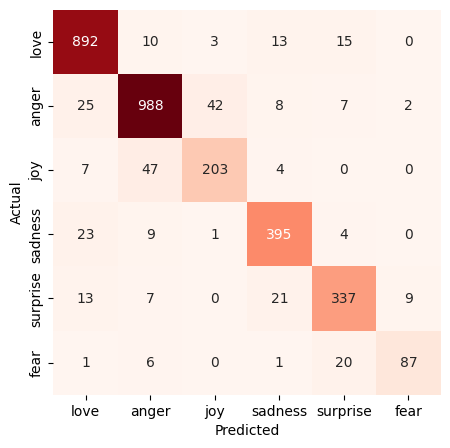

In [39]:
# این خط، ماتریس درهم‌ریختگی را با استفاده از برچسب‌های واقعی و پیش‌بینی‌های مدل محاسبه می‌کند
cm = confusion_matrix(y_true, y_pred)
# تعیین اندازه شکل برای وضوح و نمایش بهتر ماتریس درهم‌ریختگی
plt.figure(figsize=(5,5))
# cm: داده‌های ماتریس درهم‌ریختگی که باید نمایش داده شود
# annot=True: اعداد در هر خانه نمایش داده می‌شوند تا تعداد نمونه‌ها در هر خانه قابل مشاهده باشد
# از اسامی کلاس‌ها (کلیدهای label2id) برای برچسب‌های محور x و y استفاده می‌شود تا نشان دهد هر ردیف و ستون متعلق به کدام کلاس است
# fmt='d': فرمت اعداد در خانه‌ها را به اعداد صحیح (integer) تنظیم می‌کند
# cbar=False: از نمایش نوار رنگی (color bar) جلوگیری می‌کند، زیرا ممکن است ضروری نباشد
# cmap='Reds': رنگ‌بندی گرمایی را به طیف رنگ‌های قرمز تغییر می‌دهد. این طیف رنگ به وضوح اشتباهات مدل را نشان می‌دهد
sns.heatmap(cm, annot=True, xticklabels=label2id.keys(), yticklabels=label2id.keys(), fmt='d', cbar=False, cmap='Reds')
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()

In [40]:
text = "I am super happy today. I got it done. Finally!!"

# این کد یک تابع را تعریف می‌کند که یک متن ورودی را دریافت کرده، آن را رمزگذاری می‌کند، و با استفاده از مدل، پیش‌بینی می‌کند که متن به کدام دسته تعلق دارد. اجازه دهید هر خط را دقیقاً بررسی کنیم
def get_prediction(text):
    # برای آماده‌سازی داده ورودی جهت پیش‌بینی مدل، لازم است که متن به فرمت مورد نیاز مدل (به صورت توکن‌شده) تبدیل شود
    # to(device): این بخش داده را به دستگاه مشخص‌شده (مثلاً GPU اگر در دسترس باشد) منتقل می‌کند
    input_encoded = tokenizer(text, return_tensors='pt').to(device)
    # برای جلوگیری از محاسبات غیرضروری و بهینه‌سازی حافظه است، زیرا در اینجا فقط پیش‌بینی انجام می‌شود و نیازی به محاسبه گرادیان‌ها برای یادگیری نیست
    with torch.no_grad():
    # مدل با دریافت داده‌های ورودی، احتمالات یا خروجی‌های خام مربوط به دسته‌های مختلف را برای متن ورودی برمی‌گرداند
        outputs = model(**input_encoded)
    # شامل احتمال‌های خام برای هر دسته هستند که برای تصمیم‌گیری نهایی مورد نیاز است
    logits = outputs.logits
    # این خط مشخص می‌کند که مدل کدام دسته را با بیشترین اطمینان پیش‌بینی کرده است
    # اندکس (یا شماره) دسته‌ای را که بیشترین احتمال را در logits دارد، به دست می‌آورد و آن را در pred ذخیره می‌کند
    # dim=1: بیشترین مقدار را در بعد 1 پیدا می‌کند و اندکس آن کلاس را برمی‌گرداند
    # item(): اندکس پیش‌بینی‌شده را از قالب Tensor خارج می‌کند تا به شکل یک مقدار ساده باشد
    # این خط مشخص می‌کند که مدل کدام دسته را با بیشترین اطمینان پیش‌بینی کرده است
    pred = torch.argmax(logits, dim=1).item()
    # id2label تبدیل شماره دسته (مثلاً 0، 1، ...) به نام دسته (مثلاً "happy"، "sad"، ...) را فراهم می‌کند، و در نتیجه، نتیجه‌ای قابل‌فهم برای انسان برمی‌گردد
    return id2label[pred]

get_prediction(text)

'joy'

In [41]:
trainer.save_model("bert-base-uncased-sentiment-model")

In [42]:
# این کد، یک مدل از پیش آموزش‌دیده ذخیره‌شده را برای طبقه‌بندی متن بارگذاری می‌کند و از آن برای پیش‌بینی دسته‌بندی احساس یا موضوع چند جمله استفاده می‌کند
# یک ابزار ساده برای دسترسی به مدل‌های از پیش آموزش‌دیده است که می‌تواند انواع مختلفی از وظایف پردازش زبان طبیعی  مانند طبقه‌بندی، ترجمه، و استخراج ویژگی‌ها را با سهولت اجرا کند
from transformers import pipeline
# text-classification: این نوع وظیفه پردازش را مشخص می‌کند که در اینجا طبقه‌بندی متن است
# model= 'bert-base-uncased-sentiment-model': مسیر مدل ذخیره‌شده را تعیین می‌کند تا همان مدل آموزش‌دیده‌ی ما بارگذاری و استفاده شود
classifier = pipeline('text-classification', model= 'bert-base-uncased-sentiment-model')
# این جملات به مدل داده می‌شوند تا مدل دسته‌بندی‌های مناسب (مثلاً احساسات مثبت، منفی یا خنثی) را برای هر جمله برگرداند
classifier([text, 'hello, how are you?', "love you", "i am feeling low"])

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


[{'label': 'joy', 'score': 0.9622090458869934},
 {'label': 'joy', 'score': 0.8579554557800293},
 {'label': 'love', 'score': 0.5772160887718201},
 {'label': 'sadness', 'score': 0.9659565091133118}]